#### library & data load

In [6]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import add_dummy_feature

warnings.filterwarnings('ignore')

In [7]:
# 파일 호출
data_path: str = "../../data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [9]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


100%|██████████| 107/107 [00:02<00:00, 38.66it/s]


In [10]:
eda_df = df.loc[df["_type"] == "train"]
# 각 열에서 누락된 값의 수를 계산
missing_values = eda_df.isnull().sum()

# 누락된 값의 백분율 계산
missing_percentage = (missing_values / len(eda_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)

# 100.0인 값들만 필터링
missing_100_columns = sorted_missing_percentage[sorted_missing_percentage == 100.0].index.tolist()
non_missing_columns = sorted_missing_percentage[sorted_missing_percentage != 100.0].index.tolist()

#### Test

##### training and inference check with only market data  
1. **data proprocessing**  
    1-1. missing_100_column 제거  
    1-2. 변수간 상관계수가 0.9(treshold)보다 높은 변수쌍에 대해서는 하나만 남겨놓기  
    1-3. outlier 처리  
       
2. **model**  
    2-1. lightGBM 사용해보기  
        2-1-1. cross validation 진행  
        2-1-2. optuna로 최적 hyperparameter 탐색  
        + 추가로 feature importance 출력  
    2-2. ARIMA 사용 - 정상성 확인해보고 정상 data화 해보기  
      
3. **inference**  
    3-1. accuracy 값 비교  

###### data proprocessing

In [ ]:
# market data column
market_columns = [column for column in non_missing_columns if 'market' in column]

In [13]:
# missing 값이 0인 변수는 제거
final_col = [col for col in market_columns if col not in missing_100_columns]

# 선택된 column에 대한 df 생성
df_selected = df[['ID','_type','target'] + final_col].copy()

# eda를 위한 train df에서 선택된 column에서만
new_df = eda_df[['ID','_type','target'] + final_col].copy()
new_df.head(3)

,ID,_type,target,hourly_market-data_open-interest_binance_btc_busd_open_interest,hourly_market-data_liquidations_binance_btc_busd_short_liquidations_usd,hourly_market-data_liquidations_binance_btc_busd_long_liquidations,hourly_market-data_liquidations_binance_btc_busd_short_liquidations,hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd,hourly_market-data_funding-rates_bybit_funding_rates,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume,...,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume,hourly_market-data_funding-rates_binance_funding_rates,hourly_market-data_liquidations_binance_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_binance_all_symbol_short_liquidations_usd,hourly_market-data_open-interest_htx_global_btc_usd_open_interest,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations_usd
0,2023-01-01 00:00:00,train,2.0,3.180371e+08,0.0,0.0,0.0,0.0,0.01,2015805.0,...,16536.747967,5516.420322,0.01,197.5161,0.00000,3.412540e+07,0.0,0.0,0.0,0.0
1,2023-01-01 01:00:00,train,1.0,3.183281e+08,0.0,0.0,0.0,0.0,0.01,4032601.0,...,16557.136536,4513.341881,0.01,0.0000,11833.56104,3.456750e+07,0.0,0.0,0.0,0.0
2,2023-01-01 02:00:00,train,1.0,3.179729e+08,0.0,0.0,0.0,0.0,0.01,857595.0,...,16548.149805,4310.904314,0.01,0.0000,0.00000,3.452090e+07,0.0,0.0,0.0,0.0


In [14]:
# data의 describe 정보 살피기
new_df.describe()

,target,hourly_market-data_open-interest_binance_btc_busd_open_interest,hourly_market-data_liquidations_binance_btc_busd_short_liquidations_usd,hourly_market-data_liquidations_binance_btc_busd_long_liquidations,hourly_market-data_liquidations_binance_btc_busd_short_liquidations,hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd,hourly_market-data_funding-rates_bybit_funding_rates,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_ratio,...,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume,hourly_market-data_funding-rates_binance_funding_rates,hourly_market-data_liquidations_binance_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_binance_all_symbol_short_liquidations_usd,hourly_market-data_open-interest_htx_global_btc_usd_open_interest,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations_usd
count,8760.000000,8.672000e+03,8.672000e+03,8672.000000,8672.000000,8.672000e+03,8729.000000,8.730000e+03,8.730000e+03,8730.000000,...,8760.000000,8760.000000,8760.000000,8.760000e+03,8.760000e+03,8.760000e+03,8760.000000,8760.000000,8.760000e+03,8.760000e+03
mean,1.518379,2.310152e+08,1.309070e+04,0.433063,0.494221,1.119782e+04,0.007139,1.013806e+07,9.919163e+06,0.506778,...,28797.311293,5068.806648,0.007359,1.368185e+05,1.529250e+05,3.454263e+07,2.421750,2.237685,6.863825e+04,6.520109e+04
std,0.776190,9.404500e+07,7.348575e+04,3.047627,2.898927,7.733223e+04,0.011776,1.099211e+07,1.075896e+07,0.120165,...,5885.741786,7614.047475,0.006960,4.168801e+05,4.410773e+05,4.177752e+06,8.376351,9.508053,2.337151e+05,2.804281e+05
min,0.000000,2.543361e+07,0.000000e+00,0.000000,0.000000,0.000000e+00,-0.162248,0.000000e+00,0.000000e+00,0.000000,...,16519.005107,116.496744,-0.013206,0.000000e+00,0.000000e+00,2.534223e+07,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,1.000000,1.477813e+08,0.000000e+00,0.000000,0.000000,0.000000e+00,0.008402,3.242246e+06,3.100760e+06,0.433540,...,25927.520671,1005.763158,0.003243,8.753446e+01,3.667012e+02,3.168940e+07,0.000000,0.000000,0.000000e+00,0.000000e+00
50%,2.000000,2.687436e+08,0.000000e+00,0.000000,0.000000,0.000000e+00,0.010000,6.353326e+06,6.183679e+06,0.506282,...,27698.872221,2080.778155,0.008581,1.506911e+04,2.237728e+04,3.395395e+07,0.105000,0.051000,2.915400e+03,1.556193e+03
75%,2.000000,2.867187e+08,0.000000e+00,0.000000,0.000000,0.000000e+00,0.010000,1.282523e+07,1.270967e+07,0.582123,...,30241.233602,6001.937086,0.010000,1.170315e+05,1.316574e+05,3.687568e+07,1.254250,0.956250,3.582330e+04,2.834775e+04
max,3.000000,4.312301e+08,2.589482e+06,98.999000,125.096000,2.613695e+06,0.061192,9.597706e+07,9.625453e+07,0.976003,...,44537.263059,106106.465006,0.058947,1.623437e+07,1.684249e+07,5.347690e+07,169.736287,271.813104,4.186308e+06,8.572461e+06


In [15]:
# df의 각 column type 확인
type_df = list(new_df.dtypes)
unique_type = set(type_df)
unique_type

{dtype('float64'), dtype('O')}

In [17]:
# df의 각 column 별 변수 특성 파악
col_dic = {}
for column in new_df.columns:
    col_dic[column] = new_df[column].nunique()

# 정렬
col_dic_sorted = dict(sorted(col_dic.items(), key=lambda item: item[1]))

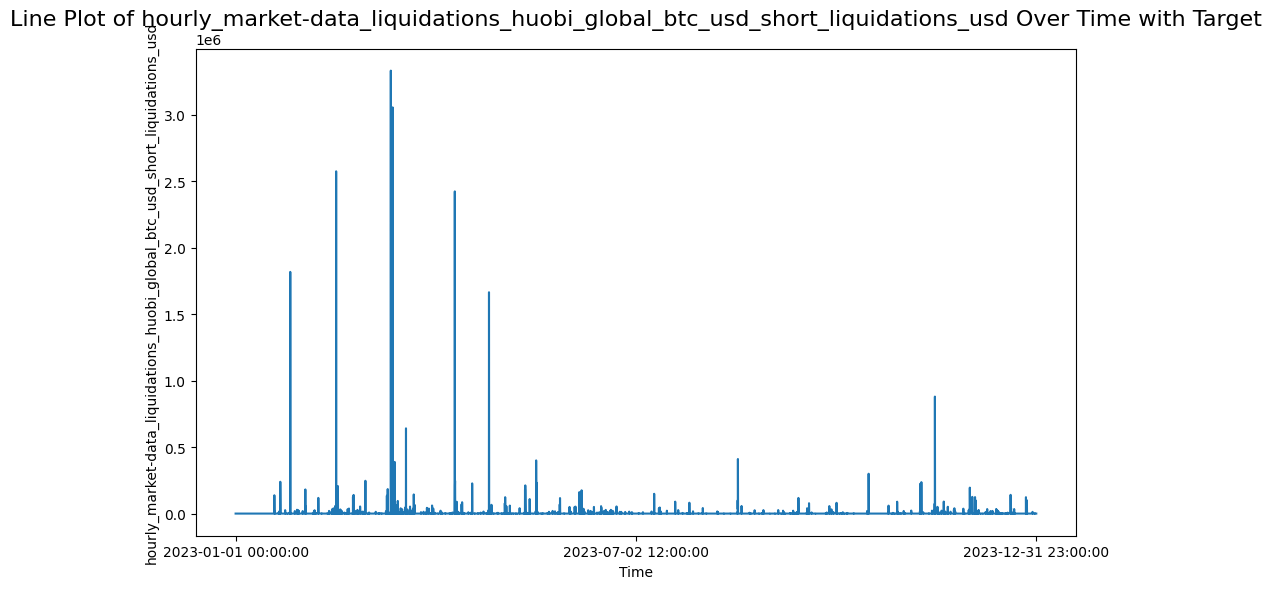

In [18]:
# 적은 unique value 값을 가진 변수들의 그래프 확인
plt.figure(figsize=(10, 6))
sns.lineplot(data=new_df, x='ID', y=list(col_dic_sorted.keys())[2])
plt.xlabel('Time')
plt.title(f'Line Plot of '+ list(col_dic_sorted.keys())[2] + ' Over Time with Target', fontsize=16)


# x축에 첨과 끝, 중간 레이블만 표시
xticks = [new_df['ID'][0], new_df['ID'][len(new_df) // 2], new_df['ID'][len(new_df)-1]]
plt.xticks(xticks)
plt.tight_layout()
plt.show()

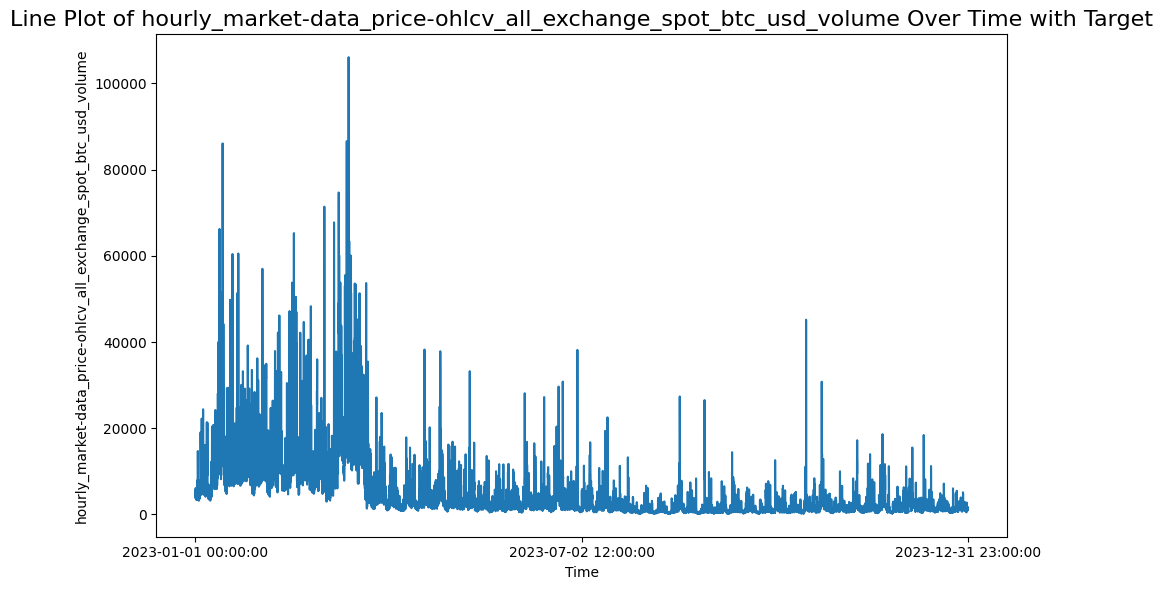

In [20]:
# 큰 unique value 값을 가진 변수들의 그래프 확인
plt.figure(figsize=(10, 6))
sns.lineplot(data=new_df, x='ID', y=list(col_dic_sorted.keys())[-1])
plt.xlabel('Time')
plt.title(f'Line Plot of '+ list(col_dic_sorted.keys())[-1] + ' Over Time with Target', fontsize=16)


# x축에 첨과 끝, 중간 레이블만 표시
xticks = [new_df['ID'][0], new_df['ID'][len(new_df) // 2], new_df['ID'][len(new_df)-1]]
plt.xticks(xticks)
plt.tight_layout()
plt.show()

In [37]:
# market에서 변수 plot 생성 함수
def plot_function(df, column):
    plt.figure(figsize=(6,4))
    sns.lineplot(data=df, x ='ID',y=column)
    plt.title(f'lineplot with {column} and time')
    
    # x축에 첨과 끝, 중간 레이블만 표시
    xticks = [df['ID'][0], df['ID'][len(df) // 2], df['ID'][len(df)-1]]
    plt.xticks(xticks)
    plt.tight_layout()
    plt.show()

In [25]:
# column 유형별 분류
liquidations = []
open_interest = []
funding_rates = []
taker_buy = []
etc = []

for col in new_df.columns:
    if 'liquidations' in col:
        liquidations.append(col)
    elif 'open_interest' in col:
        open_interest.append(col)
    elif 'funding_rates' in col:
        funding_rates.append(col)
    elif 'taker-buy' in col:
        taker_buy.append(col)
    else:
        etc.append(col)

In [29]:
print(len(liquidations), len(open_interest), len(funding_rates), len(taker_buy), len(etc))

104 28 8 40 7


In [51]:
# liquidations에 대해 높은 상관관계를 갖는 변수쌍 df 생성
liquidations_corr = new_df[liquidations].corr()
corr_matrix = liquidations_corr.where(np.triu(np.ones(liquidations_corr.shape), k=1).astype(bool))
corr_pairs = corr_matrix.stack()
corr_pairs = corr_pairs.abs().sort_index(ascending=False)
corr_pairs

hourly_market-data_liquidations_okx_btc_usdt_short_liquidations_usd        hourly_market-data_liquidations_okx_btc_usdt_long_liquidations_usd           0.071117
                                                                           hourly_market-data_liquidations_okx_btc_usdt_long_liquidations               0.079979
                                                                           hourly_market-data_liquidations_okx_btc_usd_short_liquidations_usd           0.502076
                                                                           hourly_market-data_liquidations_okx_btc_usd_short_liquidations               0.475009
                                                                           hourly_market-data_liquidations_okx_btc_usd_long_liquidations_usd            0.048243
                                                                                                                                                          ...   
hourly_market-data_liquidations_al

In [62]:
# 상관계수 임계값
threshold = 0.9

non_removed_list = []

# 높은 상관관계를 가진 변수 쌍 중 하나만 남기기S
for (col1, col2), cor in zip(corr_pairs.index, corr_pairs.values):
    if abs(cor) < threshold:

        if col1 not in non_removed_list:
            non_removed_list.append(col1)
        elif col2 not in non_removed_list:
           non_removed_list.append(col2)

non_var = list(set(non_removed_list))
len(non_var)

104

In [63]:
cor_new_df = new_df[non_var]
cor_new_df.corr()

,hourly_market-data_liquidations_bitmex_all_symbol_long_liquidations,hourly_market-data_liquidations_binance_btc_usd_long_liquidations,hourly_market-data_liquidations_huobi_global_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_deribit_all_symbol_short_liquidations_usd,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations,hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd,hourly_market-data_liquidations_bitfinex_all_symbol_short_liquidations,hourly_market-data_liquidations_gate_io_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_bitfinex_all_symbol_long_liquidations,hourly_market-data_liquidations_huobi_global_all_symbol_short_liquidations,...,hourly_market-data_liquidations_gate_io_btc_usdt_short_liquidations,hourly_market-data_liquidations_huobi_global_all_symbol_short_liquidations_usd,hourly_market-data_liquidations_htx_global_btc_usd_short_liquidations,hourly_market-data_liquidations_bybit_btc_usd_long_liquidations,hourly_market-data_liquidations_binance_btc_usdt_long_liquidations,hourly_market-data_liquidations_bybit_btc_usdt_short_liquidations_usd,hourly_market-data_liquidations_deribit_btc_usd_short_liquidations_usd,hourly_market-data_liquidations_okx_all_symbol_short_liquidations,hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_deribit_all_symbol_long_liquidations
hourly_market-data_liquidations_bitmex_all_symbol_long_liquidations,1.000000,0.326496,0.323919,0.090693,0.339839,0.037219,0.046646,0.401846,0.351213,0.000328,...,-0.000191,-0.001213,0.002404,0.202554,0.291819,0.043701,0.090696,0.019747,0.613807,0.098865
hourly_market-data_liquidations_binance_btc_usd_long_liquidations,0.326496,1.000000,0.576929,0.267028,0.593394,0.141692,0.033922,0.615518,0.298053,0.034303,...,0.064108,0.027742,0.029724,0.495666,0.711983,0.135230,0.267028,0.083214,0.744497,0.271276
hourly_market-data_liquidations_huobi_global_all_symbol_long_liquidations_usd,0.323919,0.576929,1.000000,0.059317,0.984071,0.066479,0.011050,0.678428,0.222617,0.034663,...,0.037247,0.031598,0.024853,0.424042,0.557644,0.080534,0.059324,0.037815,0.725901,0.069750
hourly_market-data_liquidations_deribit_all_symbol_short_liquidations_usd,0.090693,0.267028,0.059317,1.000000,0.059583,0.242046,0.046442,0.047365,0.086433,0.055155,...,0.097498,0.049106,0.025172,0.099191,0.255816,0.127236,1.000000,0.073277,0.186136,0.336159
hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations,0.339839,0.593394,0.984071,0.059583,1.000000,0.066024,0.010929,0.671102,0.240108,0.039099,...,0.039320,0.032185,0.031450,0.441572,0.563934,0.083846,0.059590,0.039468,0.724452,0.073747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hourly_market-data_liquidations_bybit_btc_usdt_short_liquidations_usd,0.043701,0.135230,0.080534,0.127236,0.083846,0.548690,0.179283,0.086471,0.061104,0.401166,...,0.404016,0.391496,0.131066,0.131048,0.145255,1.000000,0.127241,0.323485,0.134506,0.076125
hourly_market-data_liquidations_deribit_btc_usd_short_liquidations_usd,0.090696,0.267028,0.059324,1.000000,0.059590,0.242044,0.046445,0.047371,0.086435,0.055161,...,0.097503,0.049112,0.025173,0.099195,0.255816,0.127241,1.000000,0.073281,0.186139,0.336159
hourly_market-data_liquidations_okx_all_symbol_short_liquidations,0.019747,0.083214,0.037815,0.073277,0.039468,0.797063,0.281953,0.053287,0.016693,0.380025,...,0.715368,0.351071,0.177063,0.084536,0.103513,0.323485,0.073281,1.000000,0.085105,0.022034
hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd,0.613807,0.744497,0.725901,0.186136,0.724452,0.136137,0.057700,0.800081,0.413435,0.043152,...,0.069944,0.039184,0.032899,0.566626,0.716186,0.134506,0.186139,0.085105,1.000000,0.302727


여기까지해봄..

outlier 확인

In [11]:
# finding index of outliers
def index_outliers(data):
  Q1 = np.percentile(data, 25)
  Q3 = np.percentile(data, 75)
  IQR = Q3 - Q1

  outlier_index_list = []
  for index, value in enumerate(data):
    if (value < Q1 - IQR*1.5) | (value > Q3 + IQR*1.5):
      outlier_index_list.append(index)
  return outlier_index_list, len(outlier_index_list)

# box plot for visualizing outlier
def outlier_box_plot(df, column):
    plt.figure(figsize=(10,8))
    sns.boxplot(data = df, x = column)

    plt.tight_layout()
    plt.show()

In [12]:
index_list = []
index_num_list = []
for column in new_df.columns[3:]:
    col_df = new_df[column]
    lst, num_lst = index_outliers(col_df)

    index_list.append(lst)
    index_num_list.append(num_lst)

In [13]:
# outlier가 많은 컬럼순으로 정렬된 df
outlier_df = pd.DataFrame({'Column' : new_df.columns[3:], 'outlier_length' : index_num_list})
outlier_df_sorted = outlier_df.sort_values(by='outlier_length', ascending=False).reset_index()
outlier_df_sorted.head(3)


,index,Column,outlier_length
0,169,hourly_market-data_liquidations_htx_global_btc...,1683
1,151,hourly_market-data_liquidations_all_exchange_a...,1641
2,167,hourly_market-data_liquidations_htx_global_btc...,1615


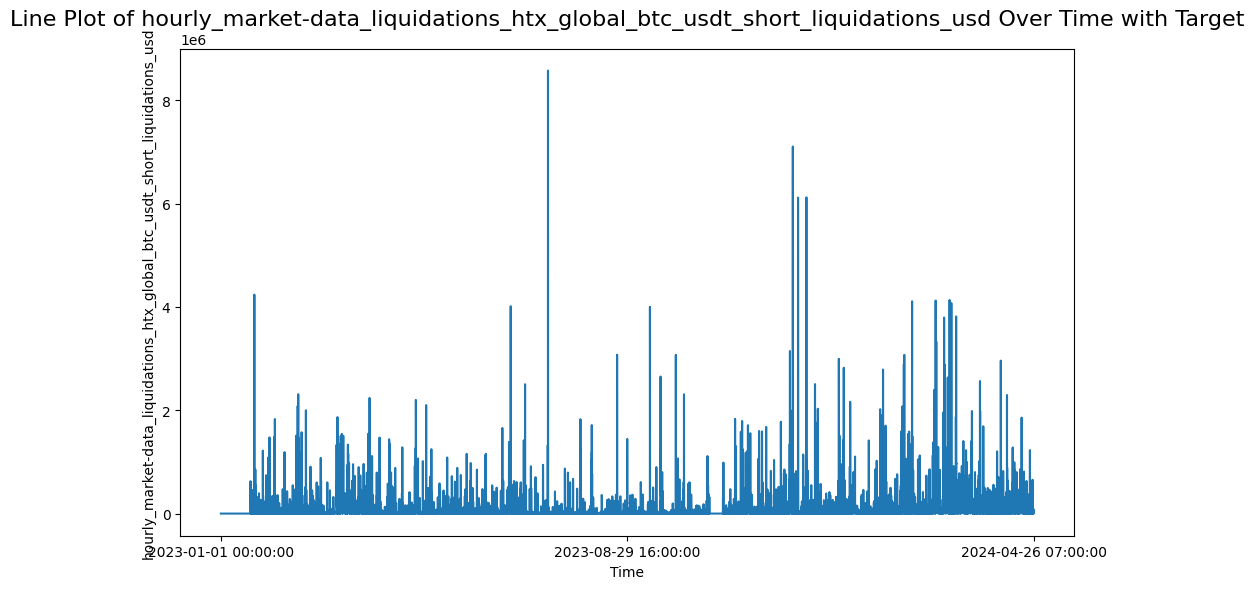

In [14]:
# outlier가 많은 column의 그래프 확인
plt.figure(figsize=(10, 6))
sns.lineplot(data=new_df, x='ID', y=outlier_df_sorted['Column'][0])
plt.xlabel('Time')
plt.title(f'Line Plot of '+ outlier_df_sorted['Column'][0] + ' Over Time with Target', fontsize=16)


# x축에 첨과 끝, 중간 레이블만 표시
xticks = [new_df['ID'][0], new_df['ID'][len(new_df) // 2], new_df['ID'][len(new_df)-1]]
plt.xticks(xticks)
plt.tight_layout()
plt.show()

In [16]:
# 각 column에 따라 outlier에 해당되는 index 값들을 NaN으로 대체
for col, outlier_index in zip(new_df.columns[3:], index_list):
    new_df.loc[outlier_index, col] = np.nan

In [17]:
new_df

,ID,_type,target,hourly_market-data_open-interest_binance_btc_busd_open_interest,hourly_market-data_liquidations_binance_btc_busd_short_liquidations_usd,hourly_market-data_liquidations_binance_btc_busd_long_liquidations,hourly_market-data_liquidations_binance_btc_busd_short_liquidations,hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd,hourly_market-data_funding-rates_bybit_funding_rates,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume,...,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close,hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume,hourly_market-data_funding-rates_binance_funding_rates,hourly_market-data_liquidations_binance_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_binance_all_symbol_short_liquidations_usd,hourly_market-data_open-interest_htx_global_btc_usd_open_interest,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations_usd
0,2023-01-01 00:00:00,train,2.0,3.180371e+08,0.0,0.0,0.0,0.0,0.01,2015805.0,...,16536.747967,5516.420322,0.010000,197.51610,0.00000,3.412540e+07,0.0,0.0,0.0,0.0
1,2023-01-01 01:00:00,train,1.0,3.183281e+08,0.0,0.0,0.0,0.0,0.01,4032601.0,...,16557.136536,4513.341881,0.010000,0.00000,11833.56104,3.456750e+07,0.0,0.0,0.0,0.0
2,2023-01-01 02:00:00,train,1.0,3.179729e+08,0.0,0.0,0.0,0.0,0.01,857595.0,...,16548.149805,4310.904314,0.010000,0.00000,0.00000,3.452090e+07,0.0,0.0,0.0,0.0
3,2023-01-01 03:00:00,train,1.0,3.179643e+08,0.0,0.0,0.0,0.0,0.01,1237990.0,...,16533.632875,4893.417864,0.010000,9754.76891,0.00000,3.438940e+07,0.0,0.0,0.0,0.0
4,2023-01-01 04:00:00,train,2.0,3.174773e+08,0.0,0.0,0.0,0.0,0.01,2423293.0,...,16524.712159,5209.002297,0.010000,5944.43714,0.00000,3.439200e+07,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11547,2024-04-26 03:00:00,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2287006.0,...,NaN,NaN,0.004867,36502.94223,0.00000,4.281260e+07,NaN,NaN,NaN,NaN
11548,2024-04-26 04:00:00,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4852344.0,...,NaN,NaN,0.006169,273829.68959,2582.91040,4.275070e+07,NaN,NaN,NaN,NaN
11549,2024-04-26 05:00:00,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8300391.0,...,NaN,NaN,NaN,13683.81333,43172.43989,4.277180e+07,NaN,NaN,NaN,NaN
11550,2024-04-26 06:00:00,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3773806.0,...,NaN,NaN,NaN,33730.60191,1230.34824,4.266640e+07,NaN,NaN,NaN,NaN
